In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
plt.style.use('ggplot')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf
import pmdarima as pm

import warnings
warnings.filterwarnings("ignore")

In [2]:
air = pd.read_csv('datasets/airline_passengers.csv')
air.head(3)

Month  AirPassengers
0  1949-01            112
1  1949-02            118
2  1949-03            132

In [3]:
air['Month'] = pd.to_datetime(air.Month)
air.set_index('Month', inplace=True)

In [4]:
# Null Values?
air.isnull().sum()

AirPassengers    0
dtype: int64

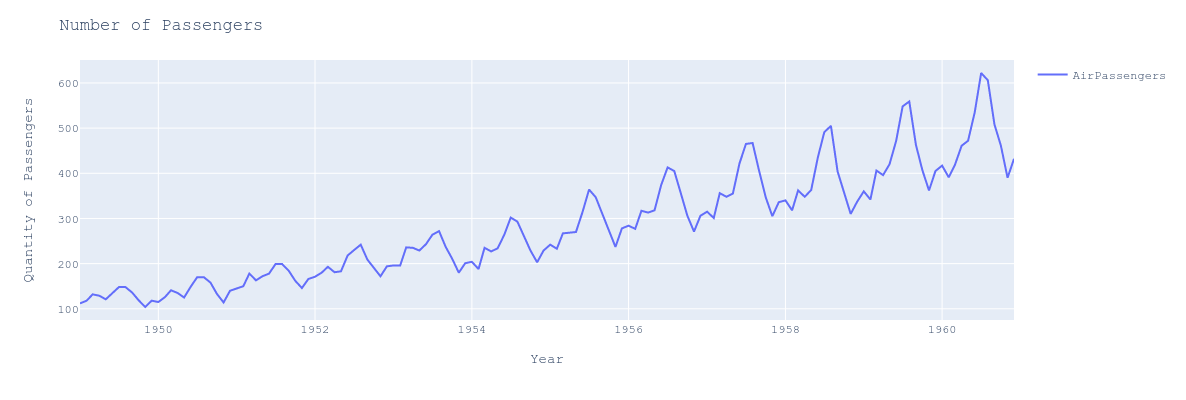

In [5]:
fig = px.line(air.AirPassengers, height=400)
fig.update_layout(
    title="Number of Passengers",
    xaxis_title="Year",
    yaxis_title="Quantity of Passengers",
    legend_title="",
    height=400,
    font=dict(
        family="Courier New, monospace",
        size=12))
fig.show()

In [6]:
# Repeated dates?
air[air.index.duplicated()].sum()

AirPassengers    0.0
dtype: float64

In [7]:
air.describe()

AirPassengers
count     144.000000
mean      280.298611
std       119.966317
min       104.000000
25%       180.000000
50%       265.500000
75%       360.500000
max       622.000000

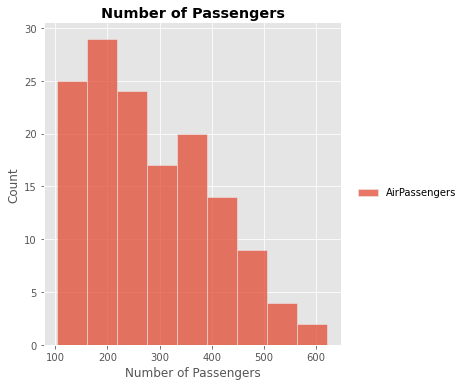

In [8]:
sns.displot(air)
plt.title("Number of Passengers", fontweight='bold')
plt.xlabel("Number of Passengers")
plt.show()

In [9]:
def extractTime(df):
    df["year"] = df.index.year
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    #df["weekday"] = df.index.weekday
    #df["hour"] = df.index.hour
    return df

air_df = extractTime(air)
air_df.head()

AirPassengers  year  quarter  month
Month                                          
1949-01-01            112  1949        1      1
1949-02-01            118  1949        1      2
1949-03-01            132  1949        1      3
1949-04-01            129  1949        2      4
1949-05-01            121  1949        2      5

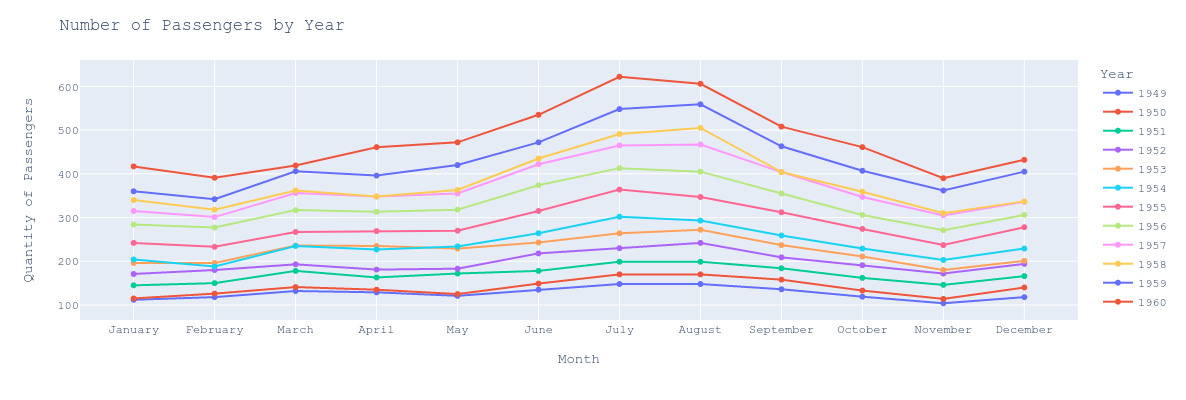

In [10]:
fig = px.line(x="month", y="AirPassengers", line_group="year", data_frame=air_df,
             color="year", markers=True)
fig.update_layout(
    title="Number of Passengers by Year",
    xaxis_title="Month",
    yaxis_title="Quantity of Passengers",
    legend_title="Year",
    height=400,
    font=dict(
        family="Courier New, monospace",
        size=12))
fig.update_xaxes(
    ticktext=["January","February","March","April","May","June","July","August",
             "September","October","November","December"],
    tickvals=[1,2,3,4,5,6,7,8,9,10,11,12]
)
fig.show()

### Number of Passengers Yearly

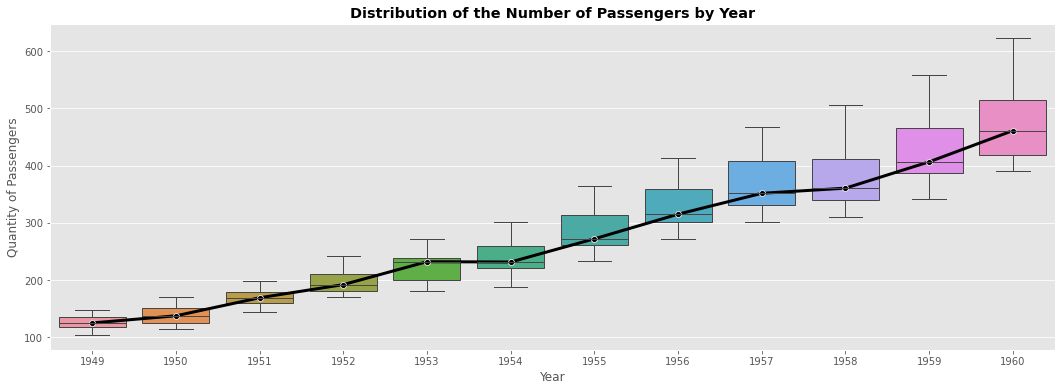

In [11]:
plt.figure(figsize=(18,6))
plt.title("Distribution of the Number of Passengers by Year", fontweight='bold')
sns.boxplot(x=air_df.year, y=air_df.AirPassengers, linewidth=1)

air_yearly = air_df.groupby('year')['AirPassengers'].median()
sns.lineplot(x=air_yearly.index-1949, y=air_yearly.values,
            marker='o', linewidth=3, color='k')
plt.xlabel("Year")
plt.ylabel("Quantity of Passengers")
plt.show()

### Number of Passengers Quarterly

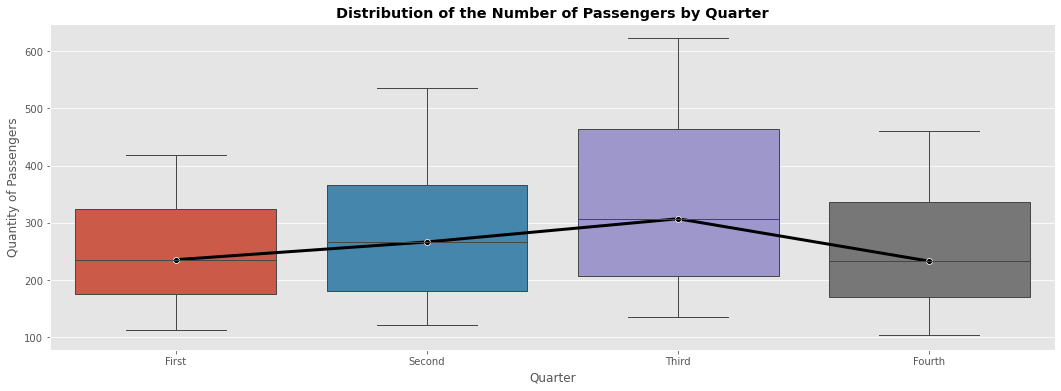

In [12]:
plt.figure(figsize=(18,6))
plt.title("Distribution of the Number of Passengers by Quarter", fontweight='bold')
sns.boxplot(x=air_df.quarter, y=air_df.AirPassengers, linewidth=1)

air_quarterly = air_df.groupby('quarter')['AirPassengers'].median()
sns.lineplot(x=air_quarterly.index-1, y=air_quarterly.values,
            marker='o', linewidth=3, color='k')
plt.xlabel("Quarter")
plt.ylabel("Quantity of Passengers")
plt.xticks(ticks=[0,1,2,3], labels=["First","Second","Third","Fourth"])
#plt.savefig("distbyyaer.jpg")
plt.show()

### Number of Passengers Monthly

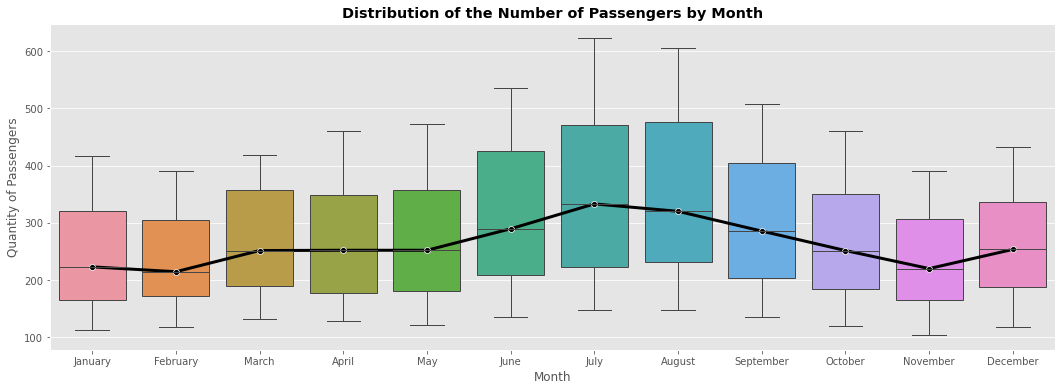

In [13]:
plt.figure(figsize=(18,6))
plt.title("Distribution of the Number of Passengers by Month", fontweight='bold')
sns.boxplot(x=air_df.month, y=air_df.AirPassengers, linewidth=1)

air_monthly = air_df.groupby('month')['AirPassengers'].median()
sns.lineplot(x=air_monthly.index-1, y=air_monthly.values,
            marker='o', linewidth=3, color='k')
month_names = ['January','February','March','April','May','June', 'July',
              'August','September','October','November','December']
plt.xticks(ticks=np.arange(12), labels=month_names)
plt.xlabel("Month")
plt.ylabel("Quantity of Passengers")
#plt.savefig("passbymonth.jpg")
plt.show()

# 2. Forecast

## 2.1 ARIMA Model

### 2.1.1 Augmented Dickey-Fuller Test

In [14]:
def adFullerResult(df):
    result = adfuller(df)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

adFullerResult(air.AirPassengers)

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


#### 2.1.2 Differencing

##### 2.1.2.1 First Differencing

In [15]:
# First Differencing
air_diff = air.AirPassengers.diff().dropna()

adFullerResult(air_diff)

ADF Statistic: -2.829267
p-value: 0.054213
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


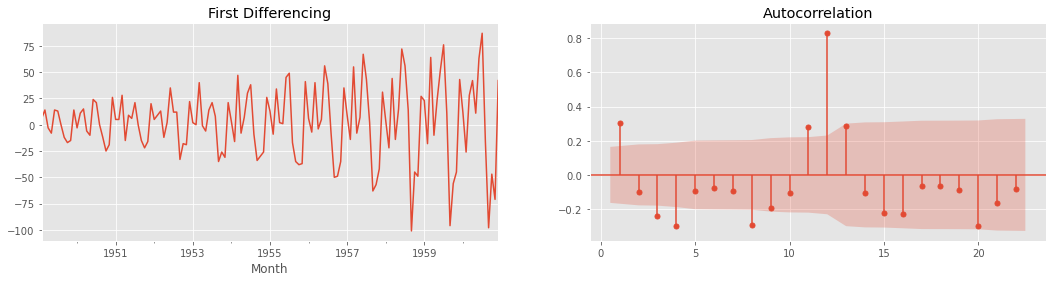

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))

air_diff.plot(ax=ax[0])
ax[0].set_title("First Differencing")
plot_acf(air_diff, zero=False, ax=ax[1])
plt.show()

##### 2.1.2.2 Second Differencing

In [17]:
air_diff2 = air_diff.diff().dropna()

adFullerResult(air_diff2)

ADF Statistic: -16.384232
p-value: 0.000000
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


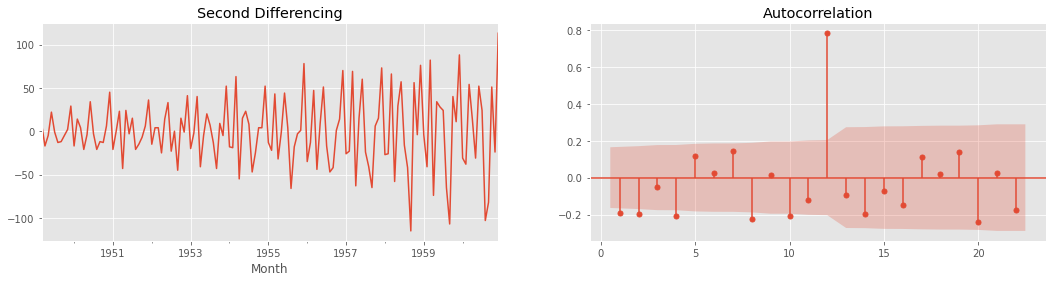

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))

air_diff2.plot(ax=ax[0])
ax[0].set_title("Second Differencing")
plot_acf(air_diff2, zero=False, ax=ax[1])
plt.show()

### 2.1.3 Autocorrelation and Partial Autocorrelation

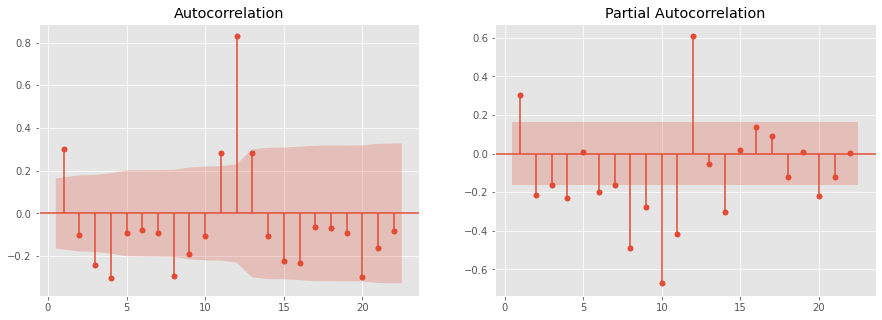

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plot_acf(air_diff, zero=False, ax=ax[0])
plot_pacf(air_diff, zero=False, ax=ax[1])
plt.show()

### 2.1.4 Searching for better order

In [20]:
akaike = list()
for p in range(1,4):
    for q in range(1,4):
        try:
            model = ARIMA(air_diff, order=(p,1,q))
            model_fit = model.fit(disp=0)
            akaike.append([p,q, model_fit.aic])
        except:
            akaike.append([p,q, None])

aic = pd.DataFrame(akaike, columns=["p","q","aic"])
aic.sort_values(by="aic", ignore_index=True, )[:3]

p  q          aic
0  1  2  1393.908442
1  1  3  1394.466729
2  2  2  1394.656208

In [21]:
# ARIMA Model
model = ARIMA(air.AirPassengers, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.AirPassengers   No. Observations:                  143
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -680.908
Method:                       css-mle   S.D. of innovations             27.910
Date:                Wed, 22 Jun 2022   AIC                           1371.815
Time:                        09:53:23   BIC                           1386.630
Sample:                    02-01-1949   HQIC                          1377.835
                         - 12-01-1960                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.6527      0.181     14.649      0.000       2.298       3.008
ar.L1.D.AirPassengers     0.5167      0.098      5.262      0.000       0.324       0.709
ma.L1.D.

### 2.1.5 ARIMA Model Diagnostic

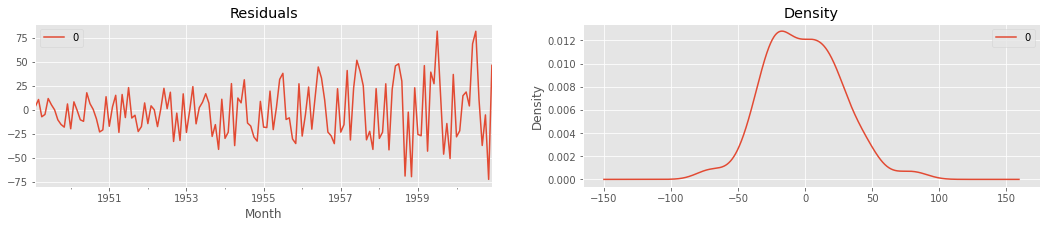

In [22]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(18,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

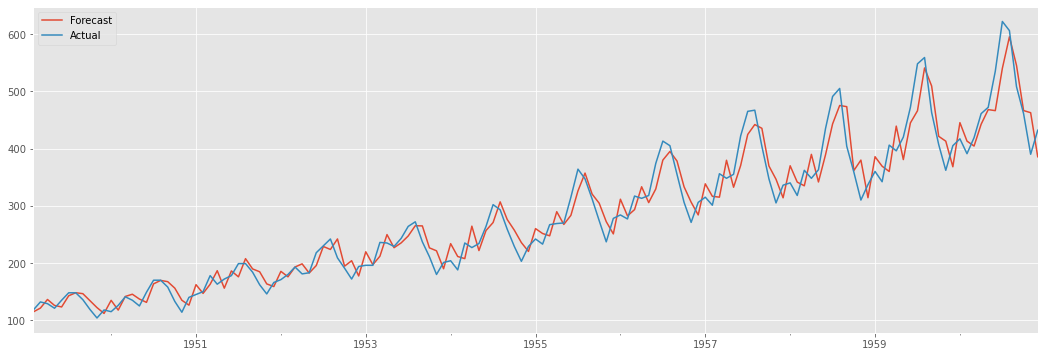

In [23]:
# Actual vs Fitted
fig, ax = plt.subplots(figsize=(18,6))
model_fit.plot_predict(dynamic=False, ax=ax)
plt.legend(["Forecast","Actual"])
plt.show()

In [24]:
# Create Training and Test set
# ==================================================================
train = air.AirPassengers[:132]
test = air.AirPassengers[132:]

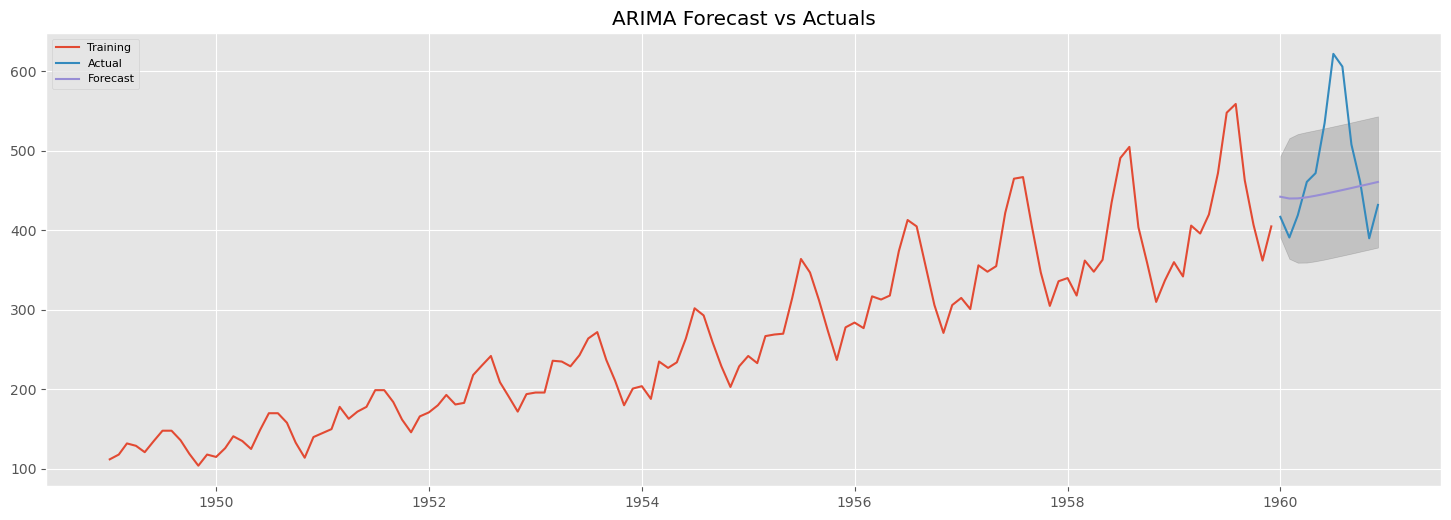

In [25]:
# Build ARIMA Model  
model = ARIMA(train, order=(1, 1, 2))  
fitted = model.fit(disp=-1)  

# ARIMA Forecast
fc, se, conf = fitted.forecast(12, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(18,6), dpi=100)
plt.plot(train, label='Training')
plt.plot(test, label='Actual')
plt.plot(fc_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('ARIMA Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### 2.1.6 ARIMA Performance Metrics

In [26]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mae = np.mean(np.abs(forecast - actual))  # MAE
    mse = np.mean(np.square(forecast - actual))  # MSE
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    rmse = np.sqrt(np.mean(np.square(forecast - actual)))  # RMSE
    
    return({'mae':mae, 'mse':mse, 'mape':mape, 'rmse':rmse})


In [27]:
# ARIMA Model Performance Metrics
arima_performance = forecast_accuracy(test.values, fc)
print("ARIMA Performance:")
print("="*24)
for k, v in arima_performance.items():
    print(k +" : "+ str(v))

ARIMA Performance:
mae : 59.90699137604986
mse : 6289.695932144528
mape : 0.133440283248243
rmse : 79.30760324297115


## 2.2 Auto ARIMA

### 2.2.1 Building Auto ARIMA Model

In [28]:
# Auto ARIMA Model
auto_model = pm.auto_arima(air.AirPassengers, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1412.973, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2057.847, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1410.569, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1417.450, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1411.319, Time=0.20 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1411.135, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1413.093, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1408.249, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1409.748, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1413.639, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1408.287, T

### 2.2.2 Auto ARIMA Model Diagnostic

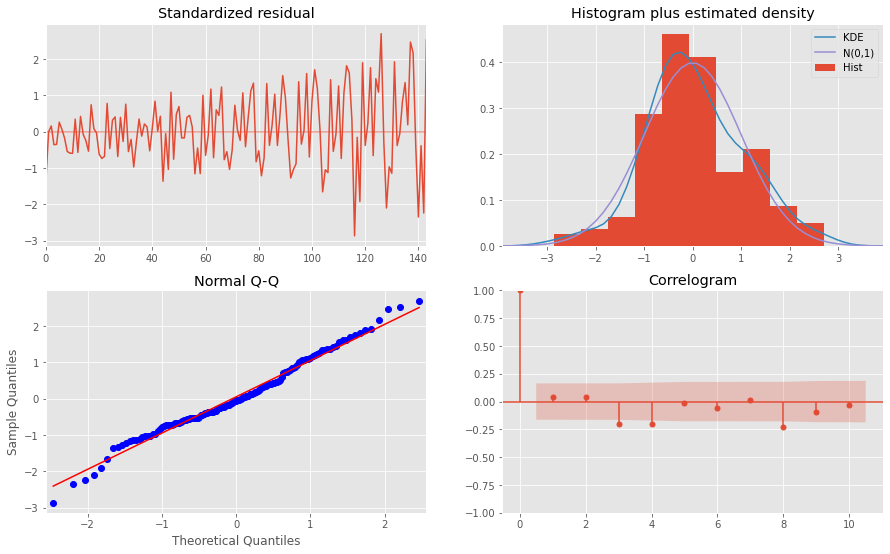

In [29]:
# Diagnostics plots
auto_model.plot_diagnostics(figsize=(15,9))
plt.show()

### 2.2.3 Auto ARIMA Forecasting

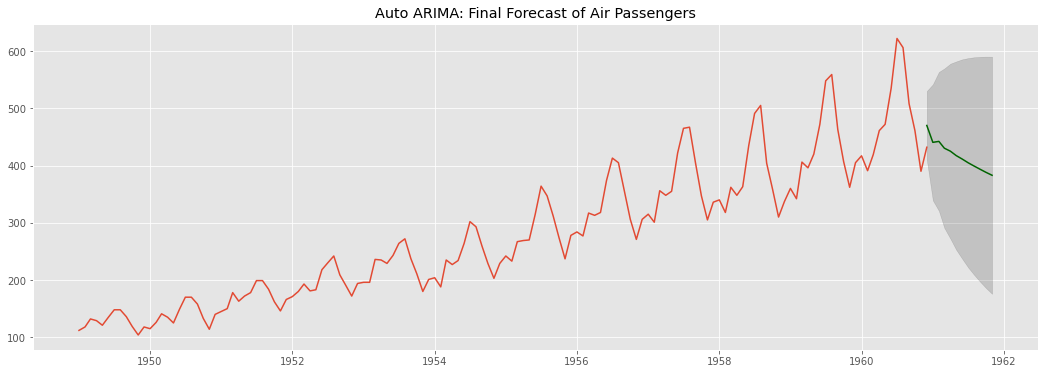

In [30]:
# Auto ARIMA Forecast
n_periods = 12  # In months
auto_fc, auto_confint = auto_model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(air.AirPassengers.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
auto_fc_series = pd.Series(auto_fc, index=index_of_fc)
lower_series = pd.Series(auto_confint[:, 0], index=index_of_fc)
upper_series = pd.Series(auto_confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(18,6))
plt.plot(air.AirPassengers)
plt.plot(auto_fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Auto ARIMA: Final Forecast of Air Passengers")
plt.show()

### 2.2.4 Auto ARIMA Performance

In [36]:
# Auto ARIMA Performance Metrics
auto_arima_performance = forecast_accuracy(test.values, auto_fc)
print("Auto ARIMA Performance:")
print("="*36)
for k, v in auto_arima_performance.items():
    print(k +" : "+ str(v))

Auto ARIMA Performance:
mae : 80.0201302543695
mse : 10539.537579166003
mape : 0.19399471795983822
rmse : 102.66225001998545


## 2.3 Seasonal ARIMA Model

### 2.3.1 Building SARIMA Model

In [32]:
# Seasonal ARIMA Model
# ===================================================================
smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

print(smodel.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=902.221, Time=0.23 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=905.065, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=900.823, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=901.721, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=899.902, Time=0.03 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=901.052, Time=0.11 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.66 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=901.337, Time=0.05 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=900.971, Time=0.05 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=900.685, Time=0.03 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=902.967, Time=0.16 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=901.457, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 1.575 seconds
                                     SARIMAX Results                                      


### 2.3.2 SARIMA Model Diagnostic

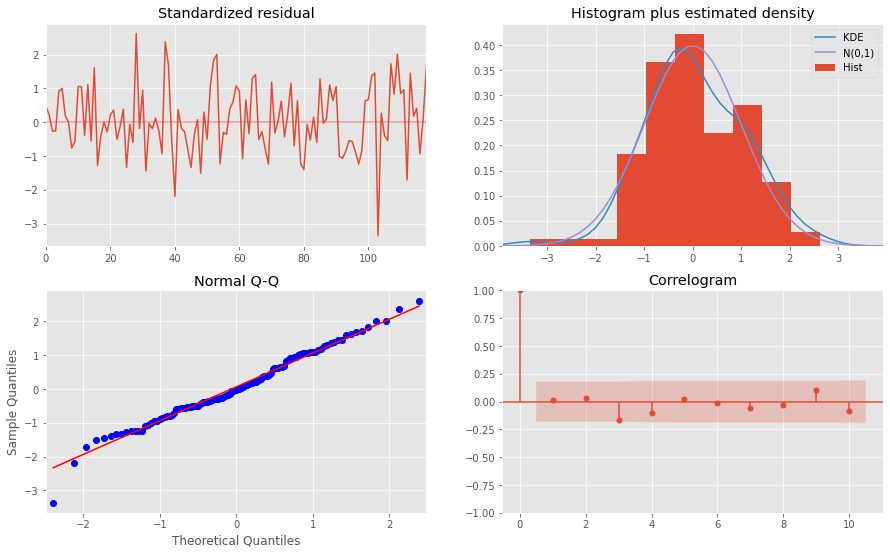

In [33]:
# Seasonal ARIMA Model Diagnostic
smodel.plot_diagnostics(figsize=(15,9))
plt.show()

### 2.3.3 SARIMA Forecasting

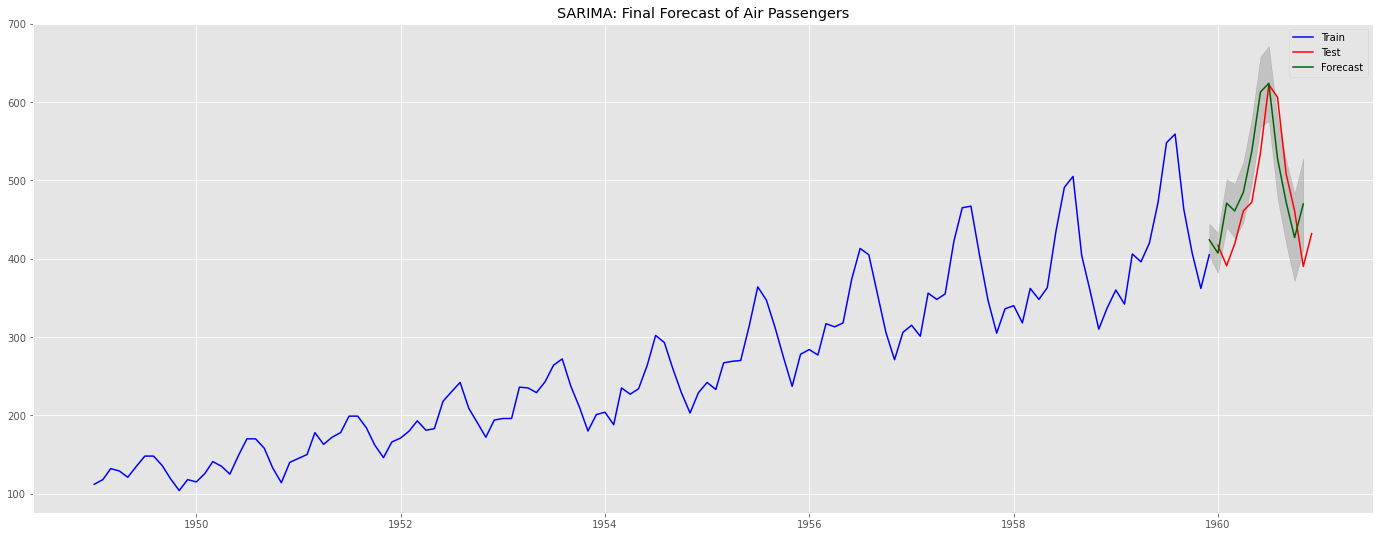

In [39]:
# Seasonal ARIMA Forecast
n_periods = 12
smodel_forecast, smodel_confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(train.index[-1], periods=n_periods, freq='MS')

# make series for plotting purpose
forecast_series = pd.Series(smodel_forecast, index=index_of_fc)
lower_series = pd.Series(smodel_confint[:, 0], index=index_of_fc)
upper_series = pd.Series(smodel_confint[:, 1], index=index_of_fc)

# Plot
fig, ax = plt.subplots(figsize=(24,9))
ax.plot(train, color="b")
ax.plot(test, color="r")
ax.plot(forecast_series, color='darkgreen')
ax.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
ax.legend(["Train","Test","Forecast"])

plt.title("SARIMA: Final Forecast of Air Passengers")
#plt.savefig("sarima_forecast.jpg")
plt.show()

### 2.3.4 SARIMA Performance Metrics

In [35]:
# Seasonal ARIMA Performance Metrics
sarima_performance = forecast_accuracy(test.values, smodel_forecast)
print("Seasonal ARIMA Performance:")
print("="*24)
for k, v in sarima_performance.items():
    print(k +" : "+ str(v))

Seasonal ARIMA Performance:
mae : 18.527653034260297
mse : 572.7249842244873
mape : 0.03897978407355824
rmse : 23.931673243308488


## Final Forecasting - SARIMA Model

In [40]:
# Seasonal ARIMA Model
# ===================================================================
smodel = pm.auto_arima(air.AirPassengers, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

print(smodel.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1022.896, Time=0.21 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.13 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.24 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.90 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.28 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.15 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.31 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.43 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.27 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1020.425, Time=0.08 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=2.01 sec
 ARIMA(0,1,1)(1,1,1)[12]     

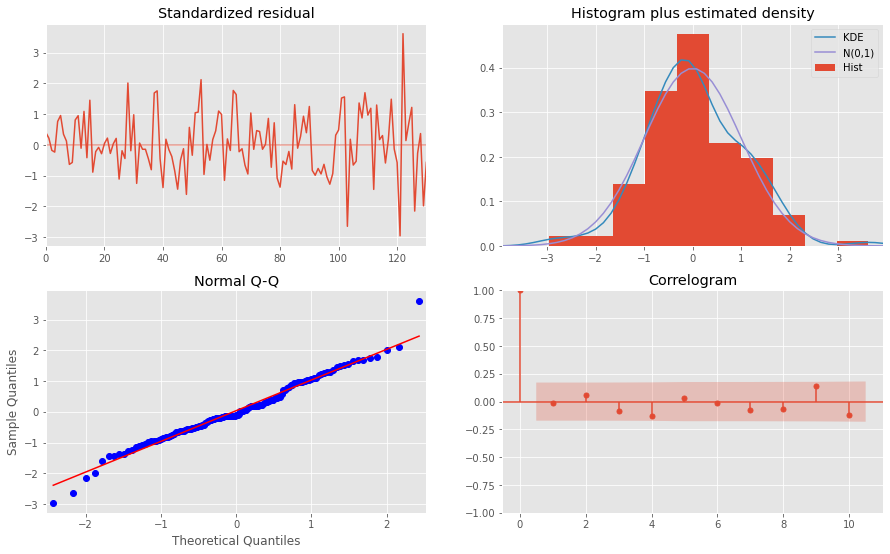

In [41]:
# Final Seasonal ARIMA Model Diagnostic
smodel.plot_diagnostics(figsize=(15,9))
plt.show()

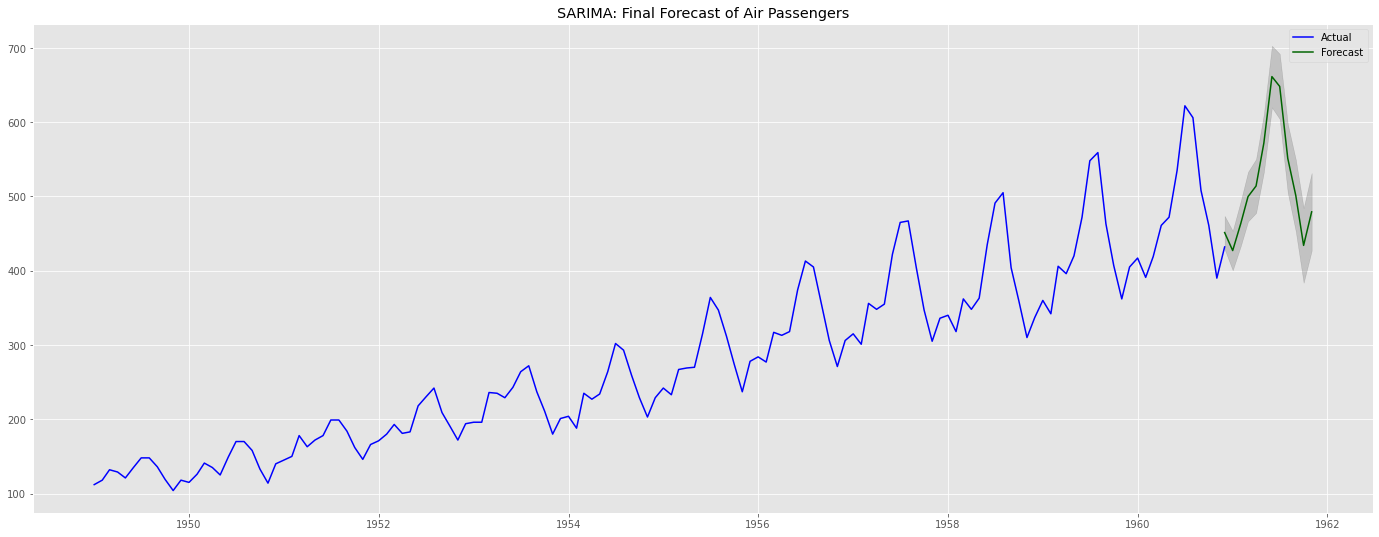

In [47]:
# Seasonal ARIMA Forecast
n_periods = 12
final_smodel_forecast, final_smodel_confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(air.AirPassengers.index[-1], periods=n_periods, freq='MS')

# make series for plotting purpose
final_forecast_series = pd.Series(final_smodel_forecast, index=index_of_fc)
lower_series = pd.Series(final_smodel_confint[:, 0], index=index_of_fc)
upper_series = pd.Series(final_smodel_confint[:, 1], index=index_of_fc)

# Plot
fig, ax = plt.subplots(figsize=(24,9))
ax.plot(air.AirPassengers, color="b")
ax.plot(final_forecast_series, color='darkgreen')
ax.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
ax.legend(["Actual","Forecast"])

plt.title("SARIMA: Final Forecast of Air Passengers")
#plt.savefig("final_sarima_forecast.jpg")
plt.show()

In [48]:
final_forecast_series

1960-12-01    451.347077
1961-01-01    427.102222
1961-02-01    463.382490
1961-03-01    499.705771
1961-04-01    514.035525
1961-05-01    571.851867
1961-06-01    661.310509
1961-07-01    648.081675
1961-08-01    551.284691
1961-09-01    501.068279
1961-10-01    434.052984
1961-11-01    479.233768
Freq: MS, dtype: float64